In [1]:
import sys
sys.path.append("../")

In [2]:
# packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import model_wrapper.backbones.model_nb101.model_nb101 as model_nb101
import model_wrapper.backbones.model_nb101.model_spec as model_spec
from utils import load_one_batch_image
import torch.optim as optim
import json
from tqdm import tqdm

In [3]:
# visualize 
dot = torch.load('../data/features/dot.pth')
net = torch.load('../data/features/net.pth')
wave_h = torch.load('../data/features/wave_h.pth')
wave_m = torch.load('../data/features/wave_m.pth')
wave_l = torch.load('../data/features/wave_l.pth')

In [4]:
print(dot.shape, net.shape, wave_h.shape, wave_m.shape, wave_l.shape)

torch.Size([64, 1024, 8, 8]) torch.Size([64, 1024, 8, 8]) torch.Size([64, 640, 8, 8]) torch.Size([64, 640, 8, 8]) torch.Size([64, 640, 8, 8])


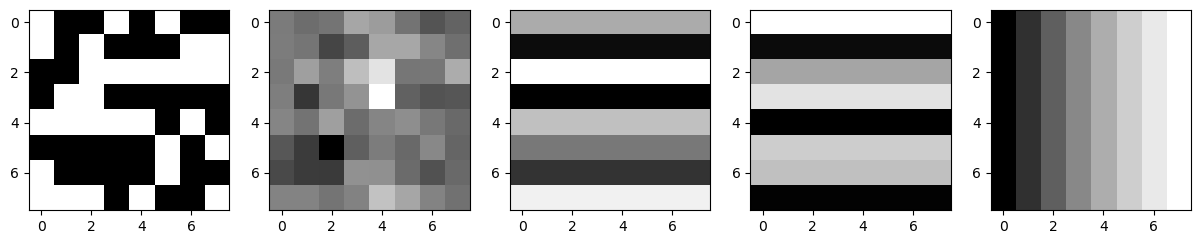

In [5]:
# visualize 5 different features
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
axs[0].imshow(dot[0, 0, :, :].detach().numpy(), cmap='gray')
axs[1].imshow(net[0, 0, :, :].detach().numpy(), cmap='gray')
axs[2].imshow(wave_h[0, 0, :, :].detach().numpy(), cmap='gray')
axs[3].imshow(wave_m[0, 0, :, :].detach().numpy(), cmap='gray')
axs[4].imshow(wave_l[0, 0, :, :].detach().numpy(), cmap='gray')
plt.show()

In [6]:
# perform GenNAS on nasbench-101
class CNNWrapper_NASBench101(nn.Module):
    def __init__(self, 
                 arch, 
                 stem_out_channels = 32, 
                 num_stacks = 3, 
                 num_modules_per_stack = 3, 
                 num_labels = 10, 
                 transform_out_channels = 64,
                 output_channels = 32):
        super().__init__()
        self.arch = arch
        self.stem_out_channels = stem_out_channels
        self.num_stacks = num_stacks
        self.num_modules_per_stack = num_modules_per_stack
        self.num_labels = num_labels
        self.transform_out_channels = transform_out_channels
        self.output_channels = output_channels
        matrix, ops = arch
        spec = model_spec._ToModelSpec(matrix, ops) # convert to model_spec
        self.nb101_nn = model_nb101.Network(spec, stem_out_channels, num_stacks, num_modules_per_stack, num_labels) # create model backbone
        self.transform_layer = nn.Sequential(
                            nn.Conv2d(stem_out_channels * 4,transform_out_channels,1,padding=0),
                            nn.ReLU(),
                            nn.BatchNorm2d(transform_out_channels)) # transform layer
        # bp: nb101_nn and transform_layer
        # untrained: barrier_layer
        self.barrier_layer = nn.Sequential(
                            nn.Conv2d(transform_out_channels,output_channels,1,padding=0)) # barrier layer (todo: untrain)
        # set barrier layer to untrain
        for param in self.barrier_layer.parameters():
            param.requires_grad = False
    def no_ffn_forward(self, x):
        # 32 x 32
        for _, layer in enumerate(self.nb101_nn.layers):
            x = layer(x)
        return x # 8 x 8
    def forward(self, x):
        x = self.no_ffn_forward(x)
        x = self.transform_layer(x)
        x = self.barrier_layer(x)
        return x

In [7]:
# load tiny model arch set
with open('../data/nb101/nasbench1_20.json', 'r') as f:
    archs_accs = json.load(f)
print('arch:', archs_accs[0][0],'acc:', archs_accs[0][1])

arch: [[[0, 1, 1, 1, 1, 0], [0, 0, 0, 1, 0, 1], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0]], ['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'output']] acc: 0.9272035300731659


In [8]:
# test model inference
model_test = CNNWrapper_NASBench101(archs_accs[0][0])
inp = torch.randn(1, 3, 32, 32)
out = model_test(inp)
print('output shape:', out.shape)

output shape: torch.Size([1, 32, 8, 8])


In [9]:
# benchmark models' performance using wave_h feature
gt = wave_h[:16,:32,:,:] # ground truth features 16 x 32 x 8 x 8
data = load_one_batch_image(type('', (), {'batch_size': 16})()) # cifar10 images 16 x 3 x 32 x 32
print(gt.shape, data.shape)
iteration = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
preds = []
accs = []
criterion = nn.MSELoss()
for arch, acc in tqdm(archs_accs):
    model = CNNWrapper_NASBench101(arch)
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    for i in range(iteration):
        optimizer.zero_grad()
        oup = model(data.to(device))
        loss = criterion(oup, gt.to(device))
        loss.backward()
        optimizer.step()

    preds.append(loss.detach().cpu())
    accs.append(acc)
print('done')

torch.Size([16, 32, 8, 8]) torch.Size([16, 3, 32, 32])
cuda:0


100%|██████████| 20/20 [01:21<00:00,  4.06s/it]

done


Text(0, 0.5, 'log loss')

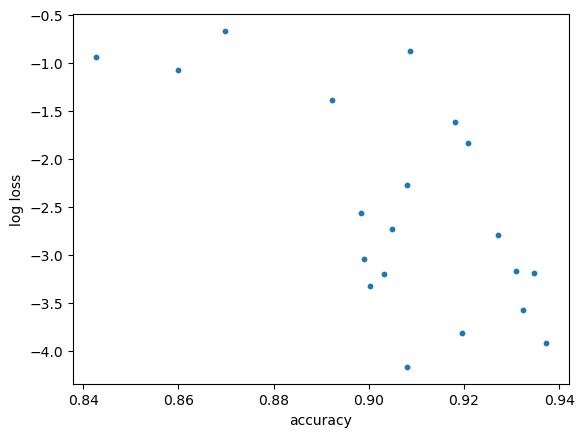

In [10]:
plt.scatter(accs, np.log(preds), s=10)
plt.xlabel('accuracy')
plt.ylabel('log loss')